# Лабораторная работа №7 #

Я выбрал датасет Football (Semantic Segmentation) https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation, потому что     Он решает актуальную задачу автоматического анализа футбольных матчей, что востребовано в спортивной аналитике, телетрансляциях и системах видеоповторов (например, VAR), а также может применяться для подсчёта статистики (положение мяча, распределение игроков), дополненной реальности (AR-графика) и автоматического выделения ключевых моментов игры.

## Импорт библиотек

In [2]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import random
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from tqdm import tqdm
import kagglehub
import json

In [3]:
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/football-semantic-segmentation


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Загрузка и проверка датасета в формате COCO

In [5]:
img_folder = os.path.join(path, "images")
file_path = sorted(os.listdir(img_folder))
print(len(file_path))

300


In [6]:
annFile = "{}/{}.json".format(path, "COCO_Football Pixel")
print(annFile)

/kaggle/input/football-semantic-segmentation/COCO_Football Pixel.json


In [7]:
from pycocotools.coco import COCO

coco = COCO(annFile)

loading annotations into memory...
Done (t=1.44s)
creating index...
index created!


In [8]:
cats = coco.loadCats(coco.getCatIds())
cats

[{'id': 1393250,
  'name': 'Goal Bar',
  'supercategory': 'Goal Bar',
  'isthing': 1,
  'color': [98, 66, 21]},
 {'id': 1392807,
  'name': 'Referee',
  'supercategory': 'Referee',
  'isthing': 1,
  'color': [167, 64, 21]},
 {'id': 1392806,
  'name': 'Advertisements',
  'supercategory': 'Advertisements',
  'isthing': 1,
  'color': [166, 64, 21]},
 {'id': 1392805,
  'name': 'Ground',
  'supercategory': 'Ground',
  'isthing': 1,
  'color': [165, 64, 21]},
 {'id': 1392804,
  'name': 'Ball',
  'supercategory': 'Ball',
  'isthing': 1,
  'color': [164, 64, 21]},
 {'id': 1392803,
  'name': 'Coaches & Officials',
  'supercategory': 'Coaches & Officials',
  'isthing': 1,
  'color': [163, 64, 21]},
 {'id': 1392802,
  'name': 'Audience',
  'supercategory': 'Audience',
  'isthing': 1,
  'color': [162, 64, 21]},
 {'id': 1392801,
  'name': 'Goalkeeper B',
  'supercategory': 'Goalkeeper B',
  'isthing': 1,
  'color': [161, 64, 21]},
 {'id': 1392800,
  'name': 'Goalkeeper A',
  'supercategory': 'Goalke

In [9]:
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
Goal Bar Referee Advertisements Ground Ball Coaches & Officials Audience Goalkeeper B Goalkeeper A Team B Team A

COCO supercategories: 
Coaches & Officials Referee Team A Goal Bar Goalkeeper A Ball Advertisements Ground Goalkeeper B Audience Team B


In [10]:
catIds = coco.getCatIds(catNms=['Team A', 'Team B', 'Goalkeeper A', 'Goalkeeper B']);
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
print(imgIds)

[1392801, 1392800, 1392799, 1392794]
[]


In [11]:
img_path = []
seg_path = []

for file in file_path:
    if 'fuse' in file:
        seg_path.append(file)
    elif 'save' in file:
        continue
    else:
        img_path.append(file)

assert len(seg_path) == len(img_path)
print(f"Number of data:", len(img_path))
print(f"Number of Seg image:", len(seg_path))

Number of data: 100
Number of Seg image: 100


## Визуализация исходных изображений и масок сегментации

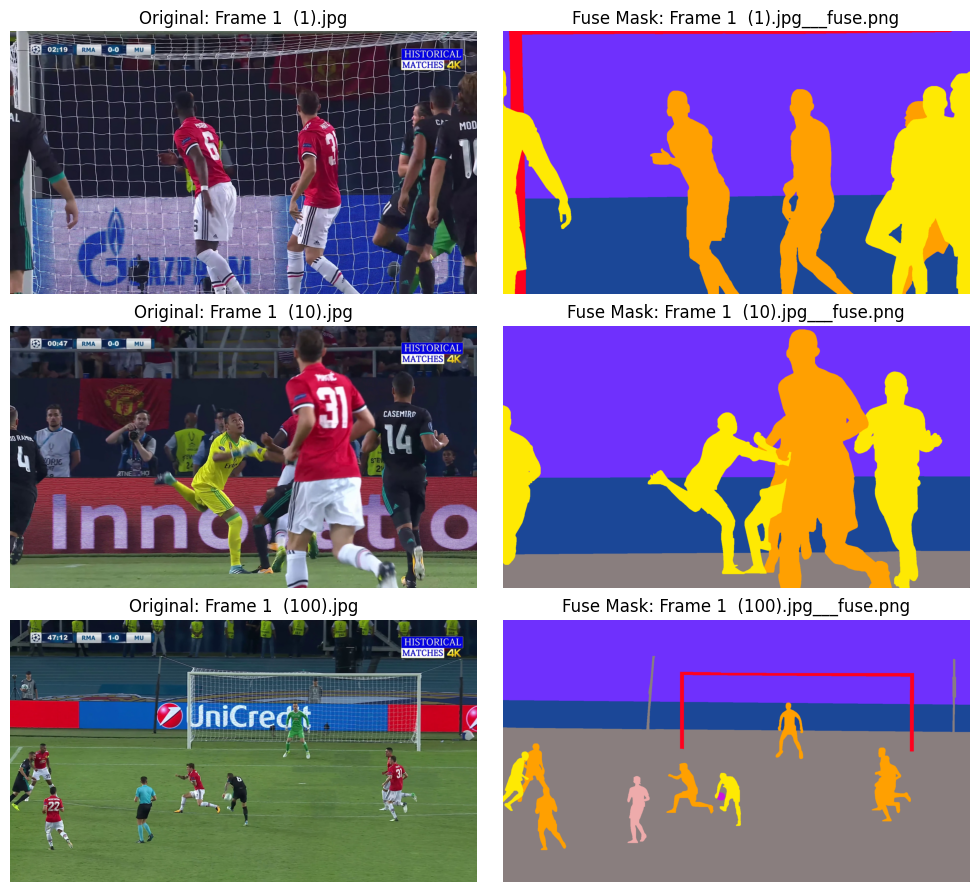

In [12]:
import cv2
import matplotlib.pyplot as plt

sample_image_pairs=[]
num_samples = 3
for img in img_path[:num_samples]:
    base_name = img.replace(".jpg", "")
    seg_sample = next((f for f in seg_path if base_name in f), None)

    if seg_sample:
        sample_image_pairs.append((img, seg_sample))

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))

for i, (img_file, seg_file) in enumerate(sample_image_pairs):
    img_sample = cv2.imread(os.path.join(img_folder, img_file))
    img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

    seg_sample = cv2.imread(os.path.join(img_folder, seg_file))
    seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_sample)
    axes[i, 0].set_title(f"Original: {img_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(seg_sample)
    axes[i, 1].set_title(f"Fuse Mask: {seg_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Определение цветовой палитры для классов сегментации

In [13]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def get_unique_colors(img_folder, seg_files, max_classes=11):
    color_set = set()

    for seg_file in seg_files:
        seg_path = os.path.join(img_folder, seg_file)
        seg = cv2.imread(seg_path, cv2.IMREAD_COLOR)
        if seg is None:
            print(f"Warning: Could not read image file: {seg_path}")
            continue
        seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
        unique_colors = np.unique(seg.reshape(-1,3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))

            if len(color_set) >= max_classes:
                return list(color_set)

    return list(color_set)
unique_colors = get_unique_colors(img_folder, seg_path)
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}

In [14]:
color_to_label

{(np.uint8(238), np.uint8(171), np.uint8(171)): 0,
 (np.uint8(254), np.uint8(233), np.uint8(3)): 1,
 (np.uint8(0), np.uint8(0), np.uint8(0)): 2,
 (np.uint8(255), np.uint8(0), np.uint8(29)): 3,
 (np.uint8(111), np.uint8(48), np.uint8(253)): 4,
 (np.uint8(137), np.uint8(126), np.uint8(126)): 5,
 (np.uint8(27), np.uint8(71), np.uint8(151)): 6,
 (np.uint8(255), np.uint8(160), np.uint8(1)): 7,
 (np.uint8(201), np.uint8(19), np.uint8(223)): 8,
 (np.uint8(255), np.uint8(159), np.uint8(0)): 9,
 (np.uint8(255), np.uint8(235), np.uint8(0)): 10}

## Создание Dataset класса с аугментацией данных

In [15]:
import albumentations as A
from torchvision.transforms import v2

transforms = A.Compose([
    A.RandomResizedCrop((256, 256), (0.5, 1)),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(0.3),
    A.VerticalFlip(0.2)
])

test_transforms = A.Compose([
    A.Resize(256,256),
])

In [16]:
class FootballData(torch.utils.data.Dataset):
    def __init__(self, img_path, seg_path, img_folder, color_to_label, transform=None):
        self.img_path = img_path
        self.seg_path = seg_path
        self.img_folder = img_folder
        self.transform = transform
        self.color_to_label = color_to_label

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path, seg_path = self.img_path[idx], self.seg_path[idx]

        image = cv2.imread(os.path.join(img_folder, image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        seg=cv2.imread(os.path.join(img_folder, seg_path))
        seg=cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

        mask_class = np.zeros(seg.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            mask_class[(seg == color).all(axis=-1)] = label

        if self.transform != None:
            augmented = self.transform(image=image, mask=mask_class)
            image, mask_class = augmented['image'], augmented['mask']

        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0
        mask_class = torch.tensor(mask_class).long()

        return image, mask_class

## Разделение данных на обучающую и тестовую выборку

In [17]:
train_dataset = FootballData(img_path, seg_path, img_folder, color_to_label, transform=transforms)
test_dataset = FootballData(img_path, seg_path, img_folder, color_to_label, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))
temp_size = int(len(train_dataset) - train_size)
val_size = int(temp_size/2)

train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, temp_size])
_, temp_dataset = torch.utils.data.random_split(test_dataset, [train_size, temp_size])

val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True)

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False, drop_last=False)



In [18]:
def plotting_img(num, dataset=None, dataset_name="Dataset", images=None, masks=None, pred_masks=None):
    plot_index = 1

    if dataset is None and "Val" in dataset_name and images is not None and masks is not None and pred_masks is not None:
        plt.figure(figsize=(10, num * 3))

        for i in range(images.size(0)):
            if plot_index > num * 3:
                break


            plt.subplot(num, 3, plot_index)
            plt.imshow(images[i].cpu().permute(1, 2, 0))
            plt.axis("off")
            if plot_index <= 3:
                plt.title("Original Image")
            plot_index += 1


            plt.subplot(num, 3, plot_index)
            plt.imshow(masks[i].cpu().numpy(), cmap="jet")
            plt.axis("off")
            if plot_index <= 3:
                plt.title("Ground Truth Mask")
            plot_index += 1


            plt.subplot(num, 3, plot_index)
            plt.imshow(pred_masks[i], cmap="jet")
            plt.axis("off")
            if plot_index <= 3:
                plt.title("Predicted Mask")
            plot_index += 1

        plt.tight_layout()
        plt.show()

    elif dataset is not None:
        if "Train" in dataset_name:
            plt.figure(figsize=(6, num * 3))
        else:
            plt.figure(figsize=(6, num * 3))

        for i in range(num):
            img, seg = dataset[i]


            plt.subplot(num, 2, plot_index)
            plt.imshow(img.cpu().permute(1, 2, 0).numpy())
            plt.axis("off")
            if plot_index <= 2:
                plt.title(f"{dataset_name} Image")
            plot_index += 1


            plt.subplot(num, 2, plot_index)
            plt.imshow(seg.cpu().numpy(), cmap='jet')
            plt.axis("off")
            if plot_index <= 2:
                plt.title("Mask")
            plot_index += 1

            if plot_index >= num * 2:
                break

        plt.tight_layout()
        plt.show()

    else:
        print("Invalid input! Please check dataset or image/mask inputs.")

### Изображения для обучения

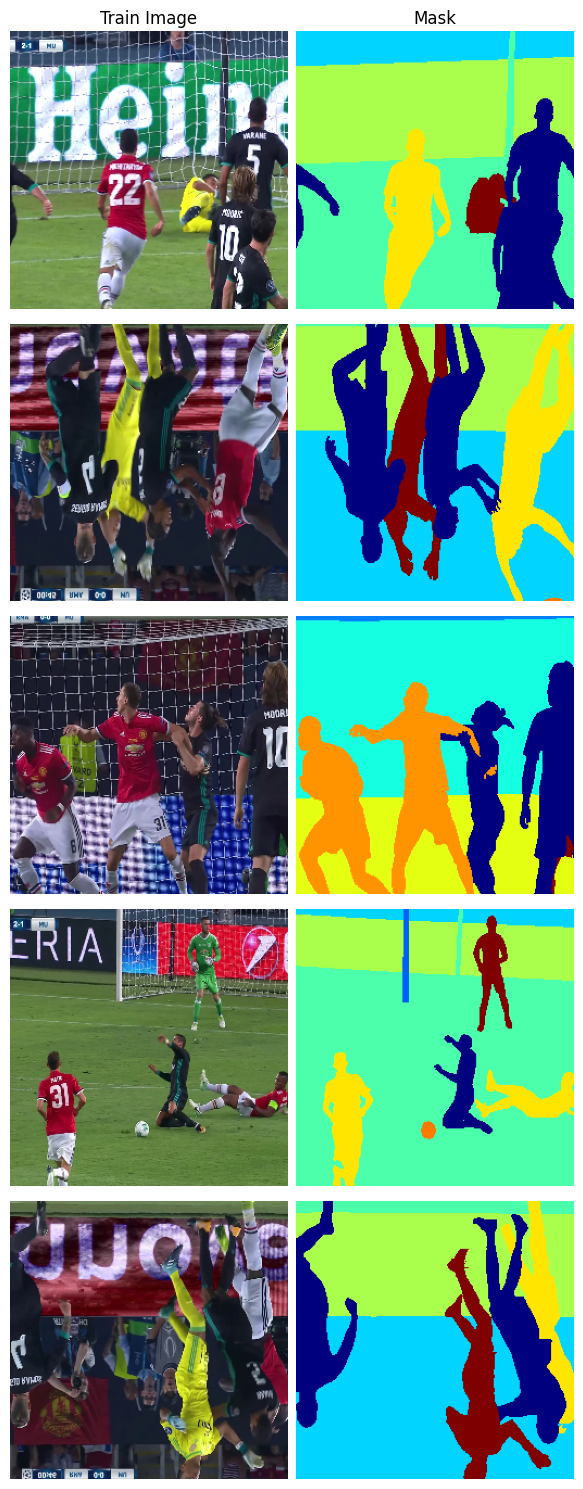

In [19]:
plotting_img(5, train_dataset, "Train")

In [20]:
pip install segmentation-models-pytorch

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Epoch 1/25: 100%|██████████| 20/20 [00:58<00:00,  2.94s/it, Loss=0.939, Acc=0.63, Dice=0.192]


Epoch 1/25
Train Loss: 0.9403 | Train Acc: 0.4308 | Train Dice: 0.1781
Val Loss: 0.9525 | Val Acc: 0.5714 | Val Dice: 0.1878
Model saved!


Epoch 2/25: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it, Loss=0.929, Acc=0.636, Dice=0.192]


Epoch 2/25
Train Loss: 0.9344 | Train Acc: 0.6628 | Train Dice: 0.1941
Val Loss: 0.9460 | Val Acc: 0.7318 | Val Dice: 0.1988
Model saved!


Epoch 3/25: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it, Loss=0.934, Acc=0.81, Dice=0.204]


Epoch 3/25
Train Loss: 0.9315 | Train Acc: 0.7485 | Train Dice: 0.2000
Val Loss: 0.9416 | Val Acc: 0.8537 | Val Dice: 0.2072
Model saved!


Epoch 4/25: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it, Loss=0.923, Acc=0.742, Dice=0.2]


Epoch 4/25
Train Loss: 0.9309 | Train Acc: 0.7621 | Train Dice: 0.2009
Val Loss: 0.9404 | Val Acc: 0.8601 | Val Dice: 0.2076
Model saved!


Epoch 5/25: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it, Loss=0.921, Acc=0.774, Dice=0.202]


Epoch 5/25
Train Loss: 0.9284 | Train Acc: 0.8017 | Train Dice: 0.2036
Val Loss: 0.9386 | Val Acc: 0.8885 | Val Dice: 0.2096
Model saved!


Epoch 6/25: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it, Loss=0.926, Acc=0.854, Dice=0.207]


Epoch 6/25
Train Loss: 0.9274 | Train Acc: 0.8106 | Train Dice: 0.2042
Val Loss: 0.9384 | Val Acc: 0.8939 | Val Dice: 0.2099
Model saved!


Epoch 7/25: 100%|██████████| 20/20 [00:43<00:00,  2.20s/it, Loss=0.933, Acc=0.877, Dice=0.209]


Epoch 7/25
Train Loss: 0.9250 | Train Acc: 0.8388 | Train Dice: 0.2062
Val Loss: 0.9398 | Val Acc: 0.7995 | Val Dice: 0.2035


Epoch 8/25: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it, Loss=0.92, Acc=0.877, Dice=0.209]


Epoch 8/25
Train Loss: 0.9246 | Train Acc: 0.8240 | Train Dice: 0.2051
Val Loss: 0.9369 | Val Acc: 0.8936 | Val Dice: 0.2099
Model saved!


Epoch 9/25: 100%|██████████| 20/20 [00:43<00:00,  2.15s/it, Loss=0.928, Acc=0.862, Dice=0.208]


Epoch 9/25
Train Loss: 0.9238 | Train Acc: 0.8381 | Train Dice: 0.2061
Val Loss: 0.9363 | Val Acc: 0.9013 | Val Dice: 0.2104
Model saved!


Epoch 10/25: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it, Loss=0.919, Acc=0.854, Dice=0.207]


Epoch 10/25
Train Loss: 0.9235 | Train Acc: 0.8548 | Train Dice: 0.2073
Val Loss: 0.9348 | Val Acc: 0.9200 | Val Dice: 0.2117
Model saved!


Epoch 11/25: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it, Loss=0.925, Acc=0.88, Dice=0.209]


Epoch 11/25
Train Loss: 0.9224 | Train Acc: 0.8359 | Train Dice: 0.2060
Val Loss: 0.9344 | Val Acc: 0.9088 | Val Dice: 0.2110
Model saved!


Epoch 12/25: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it, Loss=0.913, Acc=0.872, Dice=0.208]


Epoch 12/25
Train Loss: 0.9215 | Train Acc: 0.8638 | Train Dice: 0.2079
Val Loss: 0.9344 | Val Acc: 0.9120 | Val Dice: 0.2112


Epoch 13/25: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it, Loss=0.915, Acc=0.868, Dice=0.208]


Epoch 13/25
Train Loss: 0.9219 | Train Acc: 0.8606 | Train Dice: 0.2076
Val Loss: 0.9325 | Val Acc: 0.9300 | Val Dice: 0.2124
Model saved!


Epoch 14/25: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it, Loss=0.919, Acc=0.904, Dice=0.211]


Epoch 14/25
Train Loss: 0.9204 | Train Acc: 0.8809 | Train Dice: 0.2090
Val Loss: 0.9323 | Val Acc: 0.9231 | Val Dice: 0.2119
Model saved!


Epoch 15/25: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it, Loss=0.925, Acc=0.918, Dice=0.212]


Epoch 15/25
Train Loss: 0.9186 | Train Acc: 0.8973 | Train Dice: 0.2102
Val Loss: 0.9320 | Val Acc: 0.9257 | Val Dice: 0.2121
Model saved!


Epoch 16/25: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it, Loss=0.915, Acc=0.912, Dice=0.211]


Epoch 16/25
Train Loss: 0.9178 | Train Acc: 0.8966 | Train Dice: 0.2101
Val Loss: 0.9313 | Val Acc: 0.9330 | Val Dice: 0.2126
Model saved!


Epoch 17/25: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it, Loss=0.914, Acc=0.898, Dice=0.21]


Epoch 17/25
Train Loss: 0.9159 | Train Acc: 0.9025 | Train Dice: 0.2105
Val Loss: 0.9304 | Val Acc: 0.9355 | Val Dice: 0.2128
Model saved!


Epoch 18/25: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it, Loss=0.911, Acc=0.894, Dice=0.21]


Epoch 18/25
Train Loss: 0.9169 | Train Acc: 0.8929 | Train Dice: 0.2099
Val Loss: 0.9308 | Val Acc: 0.9209 | Val Dice: 0.2118


Epoch 19/25: 100%|██████████| 20/20 [00:43<00:00,  2.15s/it, Loss=0.918, Acc=0.947, Dice=0.214]


Epoch 19/25
Train Loss: 0.9163 | Train Acc: 0.8979 | Train Dice: 0.2102
Val Loss: 0.9299 | Val Acc: 0.9363 | Val Dice: 0.2128
Model saved!


Epoch 20/25: 100%|██████████| 20/20 [00:43<00:00,  2.15s/it, Loss=0.919, Acc=0.916, Dice=0.211]


Epoch 20/25
Train Loss: 0.9148 | Train Acc: 0.9132 | Train Dice: 0.2113
Val Loss: 0.9288 | Val Acc: 0.9393 | Val Dice: 0.2131
Model saved!


Epoch 21/25: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it, Loss=0.909, Acc=0.931, Dice=0.212]


Epoch 21/25
Train Loss: 0.9143 | Train Acc: 0.8948 | Train Dice: 0.2100
Val Loss: 0.9280 | Val Acc: 0.9357 | Val Dice: 0.2128
Model saved!


Epoch 22/25: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it, Loss=0.917, Acc=0.932, Dice=0.213]


Epoch 22/25
Train Loss: 0.9152 | Train Acc: 0.8912 | Train Dice: 0.2098
Val Loss: 0.9269 | Val Acc: 0.9350 | Val Dice: 0.2128
Model saved!


Epoch 23/25: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it, Loss=0.91, Acc=0.938, Dice=0.213]


Epoch 23/25
Train Loss: 0.9134 | Train Acc: 0.9152 | Train Dice: 0.2114
Val Loss: 0.9286 | Val Acc: 0.9241 | Val Dice: 0.2120


Epoch 24/25: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it, Loss=0.906, Acc=0.939, Dice=0.213]


Epoch 24/25
Train Loss: 0.9126 | Train Acc: 0.9116 | Train Dice: 0.2112
Val Loss: 0.9269 | Val Acc: 0.9382 | Val Dice: 0.2130
Model saved!


Epoch 25/25: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it, Loss=0.905, Acc=0.93, Dice=0.212]


Epoch 25/25
Train Loss: 0.9117 | Train Acc: 0.9171 | Train Dice: 0.2115
Val Loss: 0.9268 | Val Acc: 0.9406 | Val Dice: 0.2131
Model saved!
Test Accuracy: 0.9171
Test Dice Score: 0.2115


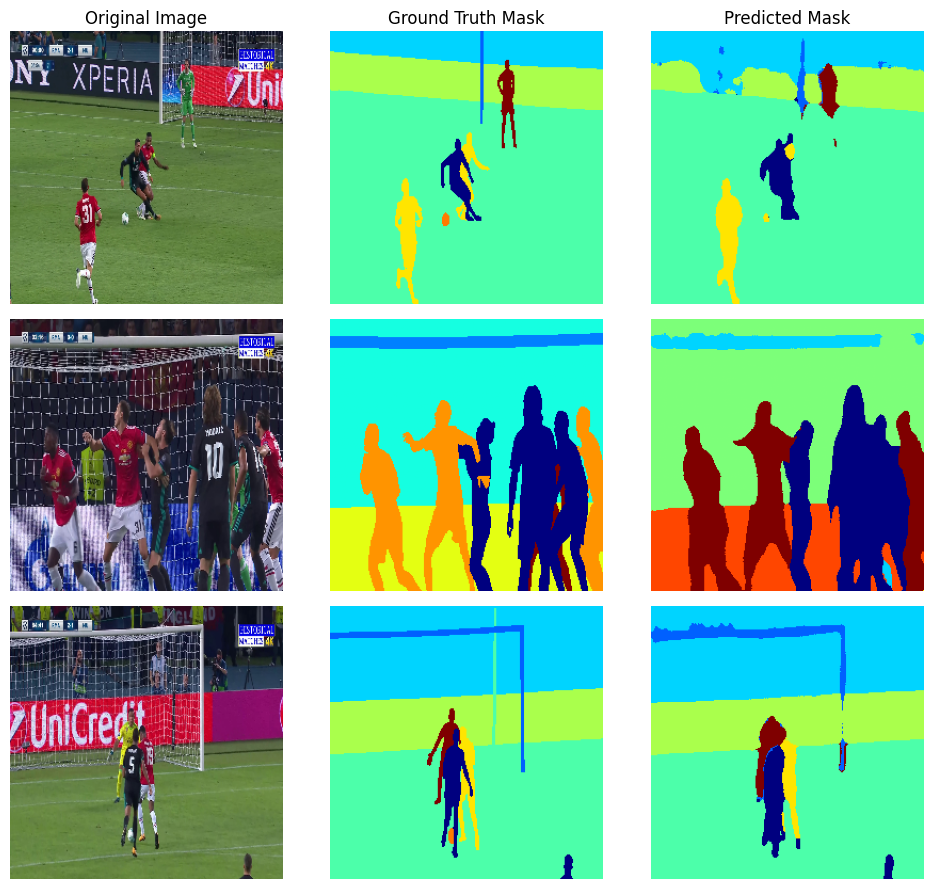

In [21]:
import torch
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50, lraspp_mobilenet_v3_large
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead


def create_unet_model(num_classes):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                           in_channels=3, out_channels=num_classes, init_features=32)
    return model


def dice_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    iflat = preds.contiguous().view(-1)
    tflat = targets.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):



        num_classes = inputs.shape[1]
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()


        probs = F.softmax(inputs, dim=1)


        dice = 0
        for cls in range(num_classes):
            intersection = (probs[:, cls] * targets_onehot[:, cls]).sum()
            union = probs[:, cls].sum() + targets_onehot[:, cls].sum()
            dice += (2. * intersection + smooth) / (union + smooth)

        return 1 - (dice / num_classes)


num_classes = len(unique_colors)
model = create_unet_model(num_classes).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss()


def calculate_metrics(preds, targets):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == targets).float().sum()
    accuracy = correct / targets.numel()

    dice = dice_score(F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float(),
                      F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float())

    return accuracy.item(), dice.item()


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_dice = 0.0


        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)


            outputs = model(images)


            if isinstance(outputs, dict):
                outputs = outputs['out']

            loss = criterion(outputs, masks)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            acc, dice = calculate_metrics(outputs, masks)

            train_loss += loss.item()
            train_acc += acc
            train_dice += dice

            pbar.set_postfix({
                'Loss': loss.item(),
                'Acc': acc,
                'Dice': dice
            })


        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']

                loss = criterion(outputs, masks)
                acc, dice = calculate_metrics(outputs, masks)

                val_loss += loss.item()
                val_acc += acc
                val_dice += dice


        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_dice /= len(train_loader)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_dice /= len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Dice: {train_dice:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Dice: {val_dice:.4f}')

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print('Model saved!')

    return model

# Запуск обучения
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

# Тестирование модели
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    test_dice = 0.0

    all_images = []
    all_masks = []
    all_preds = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']

            # Получаем предсказанные маски (классы с максимальной вероятностью)
            preds = torch.argmax(outputs, dim=1)

            # Сохраняем для визуализации
            all_images.append(images.cpu())
            all_masks.append(masks.cpu())
            all_preds.append(preds.cpu())

            # Вычисляем метрики
            acc, dice = calculate_metrics(outputs, masks)
            test_acc += acc
            test_dice += dice

    # Средние метрики
    test_acc /= len(test_loader)
    test_dice /= len(test_loader)

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Dice Score: {test_dice:.4f}')

    # Визуализация нескольких примеров
    images = torch.cat(all_images[:3], dim=0)
    masks = torch.cat(all_masks[:3], dim=0)
    preds = torch.cat(all_preds[:3], dim=0)

    plotting_img(3, dataset_name="Val Test",
                images=images, masks=masks, pred_masks=preds.numpy())

# Загрузка лучшей модели и тестирование
model.load_state_dict(torch.load('best_unet_model.pth'))
test_model(model, test_loader)

## Улучшенный бейзлайн:
 добавлена CombinedLoss, которая объединяет Dice Loss и Cross-Entropy Loss для более стабильного обучения. Использование AdamW вместо Adam (лучше для обобщения). Добавлен scheduler для адаптивного изменения learning rate. Добавлен weight decay для регуляризации


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50, fcn_resnet50
from tqdm import tqdm
from collections import defaultdict
import numpy as np

class SegmentationModel:
    def __init__(self, num_classes, device='cuda', model_type='unet'):
        self.num_classes = num_classes
        self.device = device
        self.model_type = model_type
        self.model = self._initialize_model()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 'min', patience=3, factor=0.1, verbose=True
        )
        self.criterion = self._initialize_loss()
        self.best_metrics = {'val_loss': float('inf')}

    def _initialize_model(self):
        if self.model_type == 'unet':
            model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                                 in_channels=3, out_channels=self.num_classes, init_features=32)
        elif self.model_type == 'deeplabv3':
            model = deeplabv3_resnet50(pretrained=True)
            model.classifier = DeepLabHead(2048, self.num_classes)
        elif self.model_type == 'fcn':
            model = fcn_resnet50(pretrained=True)
            model.classifier = FCNHead(2048, self.num_classes)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

        return model.to(self.device)

    def _initialize_loss(self):
        return CombinedLoss(
            dice_weight=0.7,
            ce_weight=0.3,
            num_classes=self.num_classes
        )

    def train_epoch(self, train_loader):
        self.model.train()
        metrics = defaultdict(float)

        pbar = tqdm(train_loader, desc='Training')
        for images, masks in pbar:
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            if isinstance(outputs, dict):
                outputs = outputs['out']

            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()


            acc, dice = self._calculate_metrics(outputs, masks)


            metrics['loss'] += loss.item()
            metrics['acc'] += acc
            metrics['dice'] += dice

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{acc:.4f}",
                'dice': f"{dice:.4f}"
            })


        return {k: v / len(train_loader) for k, v in metrics.items()}

    def validate_epoch(self, val_loader):
        self.model.eval()
        metrics = defaultdict(float)

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc='Validating'):
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']

                loss = self.criterion(outputs, masks)
                acc, dice = self._calculate_metrics(outputs, masks)

                metrics['loss'] += loss.item()
                metrics['acc'] += acc
                metrics['dice'] += dice

        return {k: v / len(val_loader) for k, v in metrics.items()}

    def _calculate_metrics(self, preds, targets):
        preds = torch.argmax(preds, dim=1)
        correct = (preds == targets).float().sum()
        accuracy = correct / targets.numel()

        dice = self._dice_score(
            F.one_hot(preds, self.num_classes).permute(0, 3, 1, 2).float(),
            F.one_hot(targets, self.num_classes).permute(0, 3, 1, 2).float()
        )

        return accuracy.item(), dice.item()

    def _dice_score(self, preds, targets, smooth=1e-6):
        intersection = (preds * targets).sum()
        return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    def train(self, train_loader, val_loader, num_epochs=25):
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch(train_loader)
            val_metrics = self.validate_epoch(val_loader)


            self.scheduler.step(val_metrics['loss'])


            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}, Dice: {train_metrics['dice']:.4f}")
            print(f"Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}, Dice: {val_metrics['dice']:.4f}")


            if val_metrics['loss'] < self.best_metrics['val_loss']:
                self.best_metrics = {
                    'val_loss': val_metrics['loss'],
                    'val_acc': val_metrics['acc'],
                    'val_dice': val_metrics['dice'],
                    'epoch': epoch+1
                }
                torch.save(self.model.state_dict(), f'best_{self.model_type}_model.pth')
                print(f"Model saved with val_loss: {val_metrics['loss']:.4f}")

    def evaluate(self, test_loader):
        self.model.load_state_dict(torch.load(f'best_{self.model_type}_model.pth'))
        self.model.eval()

        metrics = defaultdict(float)
        all_images, all_masks, all_preds = [], [], []

        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc='Testing'):
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']

                preds = torch.argmax(outputs, dim=1)
                acc, dice = self._calculate_metrics(outputs, masks)

                metrics['acc'] += acc
                metrics['dice'] += dice


                all_images.append(images.cpu())
                all_masks.append(masks.cpu())
                all_preds.append(preds.cpu())


        metrics = {k: v / len(test_loader) for k, v in metrics.items()}

        print(f"\nTest Results:")
        print(f"Accuracy: {metrics['acc']:.4f}")
        print(f"Dice Score: {metrics['dice']:.4f}")

        return {
            'metrics': metrics,
            'images': torch.cat(all_images),
            'masks': torch.cat(all_masks),
            'preds': torch.cat(all_preds)
        }


class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5, num_classes=None):
        super().__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.num_classes = num_classes
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        if self.num_classes is None:
            self.num_classes = inputs.shape[1]


        ce_loss = self.ce(inputs, targets)


        targets_onehot = F.one_hot(targets, self.num_classes).permute(0, 3, 1, 2).float()
        probs = F.softmax(inputs, dim=1)

        dice_loss = 0
        smooth = 1e-6
        for cls in range(self.num_classes):
            intersection = (probs[:, cls] * targets_onehot[:, cls]).sum()
            union = probs[:, cls].sum() + targets_onehot[:, cls].sum()
            dice_loss += (2. * intersection + smooth) / (union + smooth)

        dice_loss = 1 - (dice_loss / self.num_classes)

        return self.dice_weight * dice_loss + self.ce_weight * ce_loss



device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SegmentationModel(num_classes=len(unique_colors), device=device, model_type='unet')
model.train(train_loader, val_loader, num_epochs=25)
results = model.evaluate(test_loader)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validating: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]



Epoch 1/25
Train - Loss: 1.3534, Acc: 0.3971, Dice: 0.3971
Val   - Loss: 1.3769, Acc: 0.4557, Dice: 0.4557
Model saved with val_loss: 1.3769


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]



Epoch 2/25
Train - Loss: 1.3301, Acc: 0.6365, Dice: 0.6365
Val   - Loss: 1.3264, Acc: 0.7159, Dice: 0.7159
Model saved with val_loss: 1.3264


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]



Epoch 3/25
Train - Loss: 1.3187, Acc: 0.6879, Dice: 0.6879
Val   - Loss: 1.2984, Acc: 0.8356, Dice: 0.8356
Model saved with val_loss: 1.2984


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]



Epoch 4/25
Train - Loss: 1.3070, Acc: 0.7286, Dice: 0.7286
Val   - Loss: 1.2978, Acc: 0.8225, Dice: 0.8225
Model saved with val_loss: 1.2978


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]



Epoch 5/25
Train - Loss: 1.3008, Acc: 0.7470, Dice: 0.7470
Val   - Loss: 1.2919, Acc: 0.8543, Dice: 0.8543
Model saved with val_loss: 1.2919


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]



Epoch 6/25
Train - Loss: 1.2939, Acc: 0.7897, Dice: 0.7897
Val   - Loss: 1.2826, Acc: 0.8839, Dice: 0.8839
Model saved with val_loss: 1.2826


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Epoch 7/25
Train - Loss: 1.2877, Acc: 0.8131, Dice: 0.8131
Val   - Loss: 1.2794, Acc: 0.8994, Dice: 0.8994
Model saved with val_loss: 1.2794


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]



Epoch 8/25
Train - Loss: 1.2859, Acc: 0.8205, Dice: 0.8205
Val   - Loss: 1.2751, Acc: 0.8977, Dice: 0.8977
Model saved with val_loss: 1.2751


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



Epoch 9/25
Train - Loss: 1.2786, Acc: 0.8446, Dice: 0.8446
Val   - Loss: 1.2709, Acc: 0.9128, Dice: 0.9128
Model saved with val_loss: 1.2709


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



Epoch 10/25
Train - Loss: 1.2752, Acc: 0.8627, Dice: 0.8627
Val   - Loss: 1.2682, Acc: 0.8983, Dice: 0.8983
Model saved with val_loss: 1.2682


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]



Epoch 11/25
Train - Loss: 1.2686, Acc: 0.8720, Dice: 0.8720
Val   - Loss: 1.2644, Acc: 0.9273, Dice: 0.9273
Model saved with val_loss: 1.2644


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]



Epoch 12/25
Train - Loss: 1.2626, Acc: 0.8784, Dice: 0.8784
Val   - Loss: 1.2678, Acc: 0.9102, Dice: 0.9102


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



Epoch 13/25
Train - Loss: 1.2623, Acc: 0.8750, Dice: 0.8750
Val   - Loss: 1.2566, Acc: 0.9233, Dice: 0.9233
Model saved with val_loss: 1.2566


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]



Epoch 14/25
Train - Loss: 1.2594, Acc: 0.8818, Dice: 0.8818
Val   - Loss: 1.2503, Acc: 0.9329, Dice: 0.9329
Model saved with val_loss: 1.2503


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]



Epoch 15/25
Train - Loss: 1.2515, Acc: 0.9014, Dice: 0.9014
Val   - Loss: 1.2510, Acc: 0.9243, Dice: 0.9243


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]



Epoch 16/25
Train - Loss: 1.2514, Acc: 0.8892, Dice: 0.8892
Val   - Loss: 1.2419, Acc: 0.9312, Dice: 0.9312
Model saved with val_loss: 1.2419


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



Epoch 17/25
Train - Loss: 1.2507, Acc: 0.8792, Dice: 0.8792
Val   - Loss: 1.2455, Acc: 0.9326, Dice: 0.9326


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]



Epoch 18/25
Train - Loss: 1.2452, Acc: 0.8956, Dice: 0.8956
Val   - Loss: 1.2414, Acc: 0.9319, Dice: 0.9319
Model saved with val_loss: 1.2414


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]



Epoch 19/25
Train - Loss: 1.2412, Acc: 0.8993, Dice: 0.8993
Val   - Loss: 1.2397, Acc: 0.9332, Dice: 0.9332
Model saved with val_loss: 1.2397


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



Epoch 20/25
Train - Loss: 1.2369, Acc: 0.9061, Dice: 0.9061
Val   - Loss: 1.2350, Acc: 0.9374, Dice: 0.9374
Model saved with val_loss: 1.2350


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Epoch 21/25
Train - Loss: 1.2363, Acc: 0.9022, Dice: 0.9022
Val   - Loss: 1.2302, Acc: 0.9328, Dice: 0.9328
Model saved with val_loss: 1.2302


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]



Epoch 22/25
Train - Loss: 1.2344, Acc: 0.9086, Dice: 0.9086
Val   - Loss: 1.2325, Acc: 0.9342, Dice: 0.9342


Validating: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Epoch 23/25
Train - Loss: 1.2301, Acc: 0.9069, Dice: 0.9069
Val   - Loss: 1.2249, Acc: 0.9332, Dice: 0.9332
Model saved with val_loss: 1.2249


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Epoch 24/25
Train - Loss: 1.2257, Acc: 0.9077, Dice: 0.9077
Val   - Loss: 1.2230, Acc: 0.9418, Dice: 0.9418
Model saved with val_loss: 1.2230


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Epoch 25/25
Train - Loss: 1.2256, Acc: 0.9053, Dice: 0.9053
Val   - Loss: 1.2229, Acc: 0.9182, Dice: 0.9182
Model saved with val_loss: 1.2229


Testing: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Test Results:
Accuracy: 0.8404
Dice Score: 0.8404


Улучшения дали значительный рост Dice score (с 0.21 до 0.84), что говорит о том, что модель стала лучше справляться с сегментацией объектов.
Несмотря на снижение accuracy и рост Loss, основная метрика (Dice) улучшилась, значит, изменения были полезными.

# Собственная имплементация Unet

In [30]:
class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)

In [31]:
def _init_weights(m):

    if isinstance(m, nn.Conv2d):

        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):

        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):

        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):

        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [32]:
model = UNet(num_classes=11).to(device)
model.apply(_init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [33]:
def initialize_model(model, num_classes=11, load_best_model=False, device=device):
    model = model.to(device)

    if load_best_model:
        try:
            model.load_state_dict(torch.load('best_model.pth'))
            print("Successfully loaded the best model.")
        except FileNotFoundError:
            print("No saved model found. Training from scratch.")

    return model

In [34]:
def dice_score(pred, target, num_classes=11):
    smooth = 1e-6
    pred = pred.argmax(dim=1)
    dice = 0
    for i in range(num_classes):
        pred_f = (pred == i).float()
        target_f = (target == i).float()
        intersection = (pred_f * target_f).sum()
        dice += (2. * intersection + smooth) / (pred_f.sum() + target_f.sum() + smooth)
    return dice / num_classes

In [35]:
num_epochs=40
def train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=num_epochs, device=device):
    model = model.to(device)
    best_score = float('inf')
    current_lr = 0
    best_params = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_dice = 0

        if lr_scheduler:
            current_lr = optimizer.param_groups[0]['lr']

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            masks = torch.clamp(masks, min=0, max=10).long()

            optimizer.zero_grad()


            outputs = model(images)


            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()


            dice = dice_score(outputs, masks)


            total_loss += loss.item()
            total_dice += dice.item()

        if lr_scheduler:
            lr_scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)


        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice Score: {avg_dice:.4f}")


        model.eval()
        val_total_loss = 0
        val_total_dice = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = torch.clamp(masks, min=0, max=10).long()

                outputs = model(images)
                val_loss = criterion(outputs, masks)

                dice = dice_score(outputs, masks)

                val_total_loss += val_loss.item()
                val_total_dice += dice.item()

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_dice = val_total_dice / len(val_loader)
        print(f"Val Loss: {val_avg_loss:.4f}, Dice Score(Val): {val_avg_dice:.4f}")


        if val_avg_loss < best_score:
            best_score = val_avg_loss
            best_params = model.state_dict()
            print(f"Best Score(Val) Stored, {best_score:.4f}")


    if best_params:
        torch.save(best_params, 'best_model.pth')

In [36]:
def load_model(model, weight_path='best_model.pth', device=device):
    model.load_state_dict(torch.load(weight_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    print("Weights loaded for the model!")
    return model

In [37]:
def model_test(model, test_loader, visual_sample_num=10):
    model.eval()
    with torch.no_grad():
        test_batch = iter(test_loader)
        plt.figure(figsize=(15, 80))

        plot_count = 0
        for images, masks in test_batch:
            images = images.to(device)
            outputs = model(images)

            pred_masks = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()

            remaining_samples = visual_sample_num - plot_count
            batch_size = min(images.size(0), remaining_samples)

            plotting_img(batch_size, dataset_name="Val", images=images, masks=masks, pred_masks=pred_masks)

            plot_count += batch_size
            if plot_count > visual_sample_num:
                break
        plt.tight_layout()
        plt.show()

In [38]:
model.to(device)

train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=25, device=device)

Epoch [1/25], Loss: 2.5183, Dice Score: 0.1479
Val Loss: 2.1985, Dice Score(Val): 0.1601
Best Score(Val) Stored, 2.1985
Epoch [2/25], Loss: 1.3136, Dice Score: 0.2613
Val Loss: 1.4846, Dice Score(Val): 0.1643
Best Score(Val) Stored, 1.4846
Epoch [3/25], Loss: 1.0193, Dice Score: 0.3036
Val Loss: 0.7330, Dice Score(Val): 0.2763
Best Score(Val) Stored, 0.7330
Epoch [4/25], Loss: 0.8645, Dice Score: 0.3352
Val Loss: 0.5877, Dice Score(Val): 0.3071
Best Score(Val) Stored, 0.5877
Epoch [5/25], Loss: 0.7552, Dice Score: 0.3652
Val Loss: 0.5009, Dice Score(Val): 0.3392
Best Score(Val) Stored, 0.5009
Epoch [6/25], Loss: 0.6682, Dice Score: 0.3903
Val Loss: 0.4633, Dice Score(Val): 0.3480
Best Score(Val) Stored, 0.4633
Epoch [7/25], Loss: 0.5982, Dice Score: 0.4160
Val Loss: 0.4006, Dice Score(Val): 0.3656
Best Score(Val) Stored, 0.4006
Epoch [8/25], Loss: 0.5983, Dice Score: 0.4138
Val Loss: 0.4268, Dice Score(Val): 0.3552
Epoch [9/25], Loss: 0.5272, Dice Score: 0.4349
Val Loss: 0.3772, Dice S

Weights loaded for the model!


<Figure size 1500x8000 with 0 Axes>

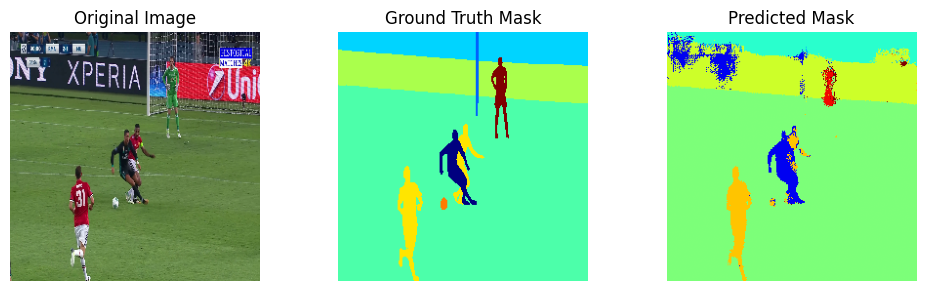

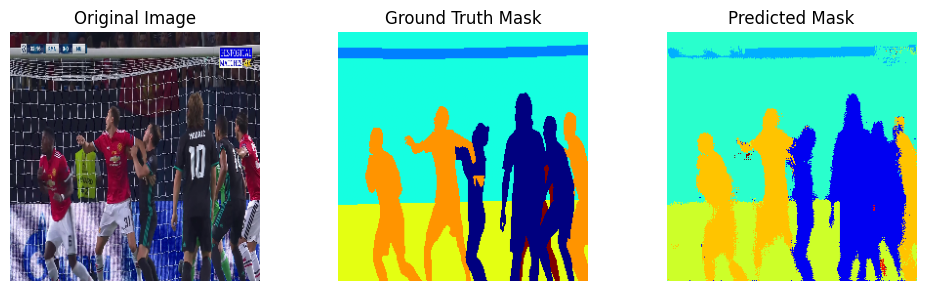

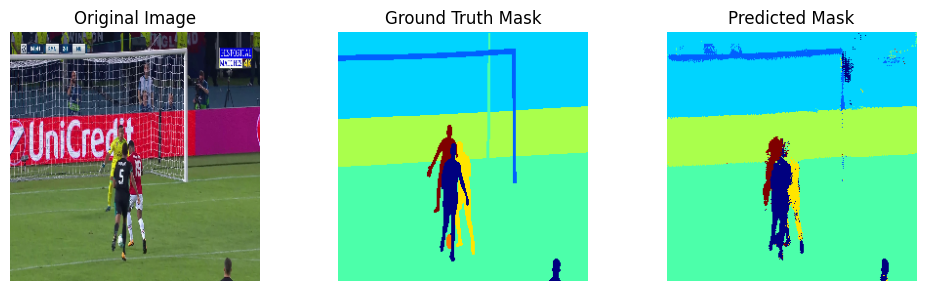

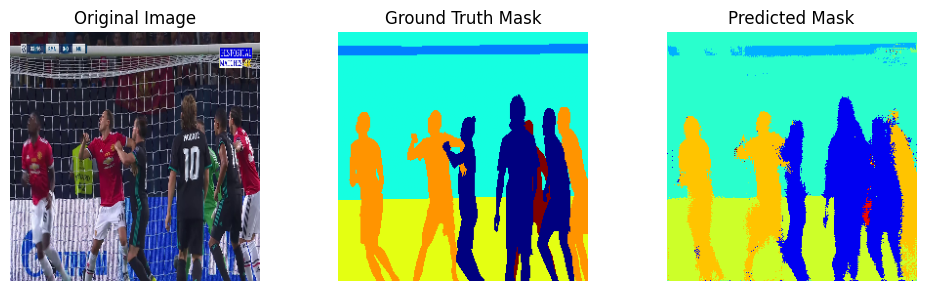

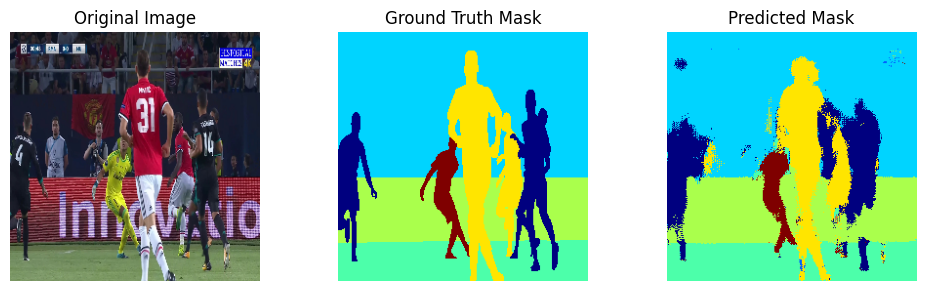

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
model = load_model(model)
model_test(model, test_loader, visual_sample_num=5)

# Улучшенный бейзлайн



In [40]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets):
        smooth = 1e-5


        preds = torch.softmax(preds, dim=1)


        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = targets.view(targets.size(0), -1)


        dice = 0
        for i in range(preds.size(1)):
            intersection = torch.sum(preds_flat[:, i, :] * (targets_flat == i).float())
            union = torch.sum(preds_flat[:, i, :]) + torch.sum((targets_flat == i).float())
            dice += (2. * intersection + smooth) / (union + smooth)

        return 1 - dice / preds.size(1)

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce

    def forward(self, preds, targets):
        dice_loss_value = self.dice_loss(preds, targets)
        ce_loss_value = self.ce_loss(preds, targets)

        combined_loss = self.weight_dice * dice_loss_value + self.weight_ce * ce_loss_value
        return combined_loss

In [41]:
class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes=11):
        super(UNetPlusPlus, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)


        self.bottleneck = conv_block(512, 1024)


        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = conv_block(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = conv_block(512+512, 256)

        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder1 = conv_block(512+256+128+128, 128)

        self.upconv0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder0 = conv_block(512 + 256 + 128 + 64 + 64, 64)


        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def dense_skip(self, x, x_0):
        if x.shape[2:] != x_0.shape[2:]:
            x = F.interpolate(x, size=x_0.shape[2:], mode='bilinear', align_corners=True)
        return x

    def forward(self, x):

        e1 = self.encoder1(x) # 64 / 256
        e2 = self.encoder2(self.pool(e1)) # 128 / 128
        e3 = self.encoder3(self.pool(e2)) # 256 / 64
        e4 = self.encoder4(self.pool(e3)) # 512 / 32


        b = self.bottleneck(self.pool(e4)) # 1024 / 16


        d3 = torch.cat((self.upconv3(b), e4), dim=1) # [512/ 32, 512 / 32]
        d3 = self.decoder3(d3) # 1024/32 -> 512/32

        e4_up = self.dense_skip(e4, e3)

        d2 = torch.cat((self.upconv2(d3), e3, e4_up), dim=1)
        d2 = self.decoder2(d2)

        e3_up = self.dense_skip(e3, e2)
        e4_up = self.dense_skip(e4_up, e2)

        d1 = torch.cat((self.upconv1(d2), e2, e3_up, e4_up), dim=1)
        d1 = self.decoder1(d1)

        e2_up = self.dense_skip(e2, e1)
        e3_up = self.dense_skip(e3_up, e1)
        e4_up = self.dense_skip(e4_up, e1)

        d0 = torch.cat((self.upconv0(d1), e1, e2_up, e3_up, e4_up), dim=1)
        d0 = self.decoder0(d0)

        return self.final_conv(d0)

In [42]:

model = UNetPlusPlus(num_classes=11)
model.apply(_init_weights)
model = model.to(device)

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
criterion = CombinedLoss(weight_dice=1.0, weight_ce=1.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs/4), eta_min=1e-6)

In [45]:
train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=scheduler, num_epochs=25, device=device)

Epoch [1/25], Loss: 1.8942, Dice Score: 0.3982
Val Loss: 4.0440, Dice Score(Val): 0.4145
Best Score(Val) Stored, 4.0440
Epoch [2/25], Loss: 1.6382, Dice Score: 0.4256
Val Loss: 1.5311, Dice Score(Val): 0.4879
Best Score(Val) Stored, 1.5311
Epoch [3/25], Loss: 1.5788, Dice Score: 0.4489
Val Loss: 1.3731, Dice Score(Val): 0.5118
Best Score(Val) Stored, 1.3731
Epoch [4/25], Loss: 1.3034, Dice Score: 0.5371
Val Loss: 1.0949, Dice Score(Val): 0.6124
Best Score(Val) Stored, 1.0949
Epoch [5/25], Loss: 1.2240, Dice Score: 0.5729
Val Loss: 1.0992, Dice Score(Val): 0.6150
Epoch [6/25], Loss: 1.0933, Dice Score: 0.6169
Val Loss: 1.1028, Dice Score(Val): 0.6052
Epoch [7/25], Loss: 1.0455, Dice Score: 0.5926
Val Loss: 1.0598, Dice Score(Val): 0.6270
Best Score(Val) Stored, 1.0598
Epoch [8/25], Loss: 0.9494, Dice Score: 0.6068
Val Loss: 0.9502, Dice Score(Val): 0.5885
Best Score(Val) Stored, 0.9502
Epoch [9/25], Loss: 0.8999, Dice Score: 0.6396
Val Loss: 0.8713, Dice Score(Val): 0.6783
Best Score(Va

Weights loaded for the model!


<Figure size 1500x8000 with 0 Axes>

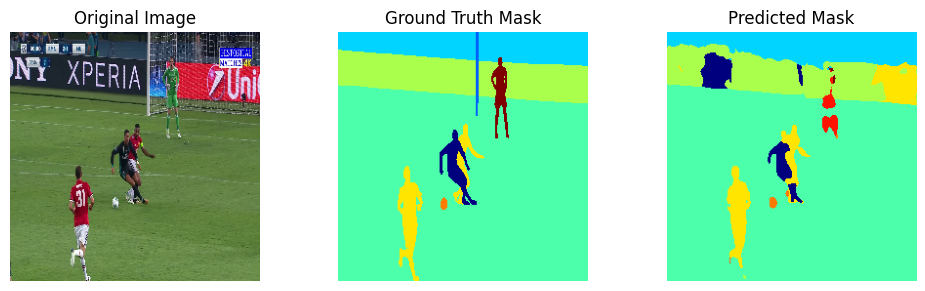

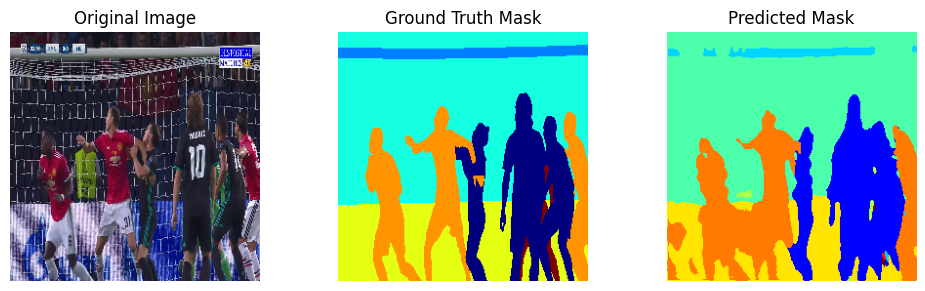

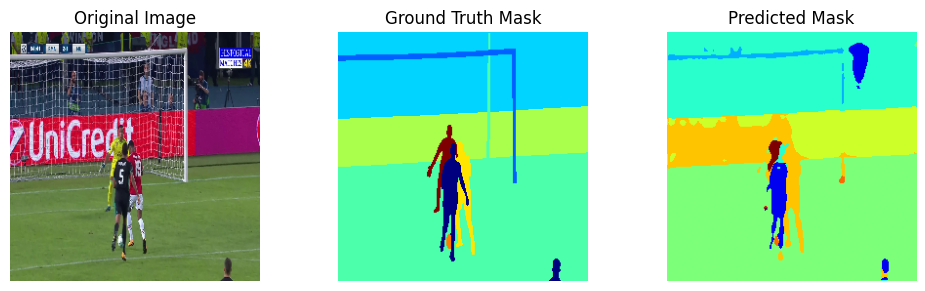

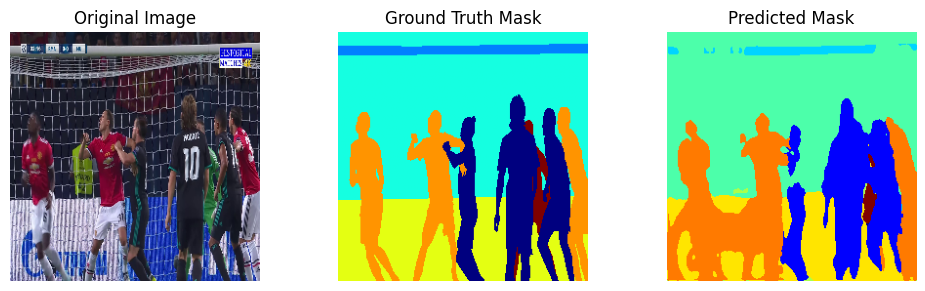

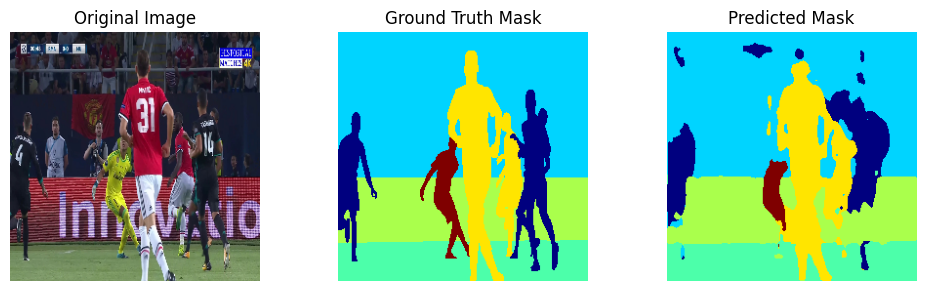

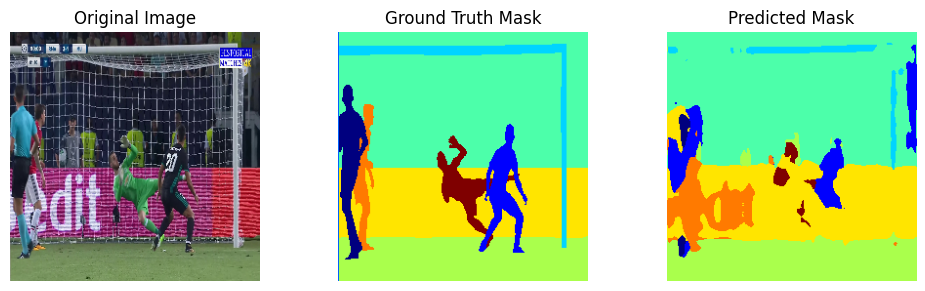

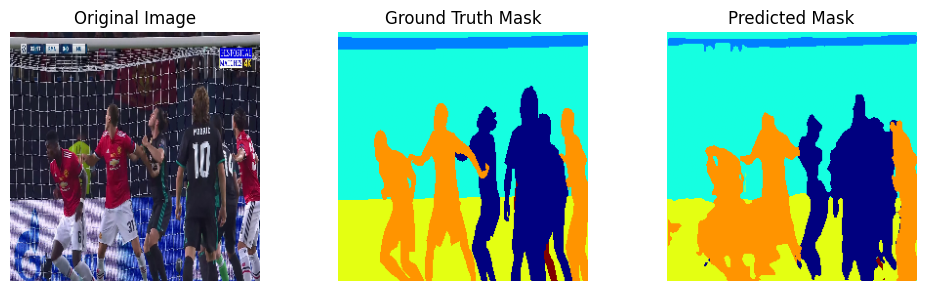

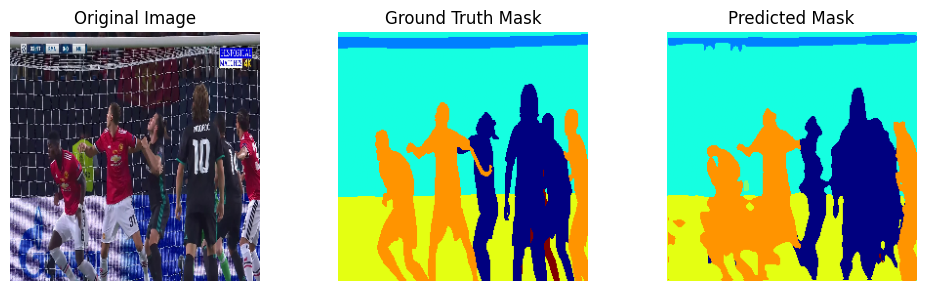

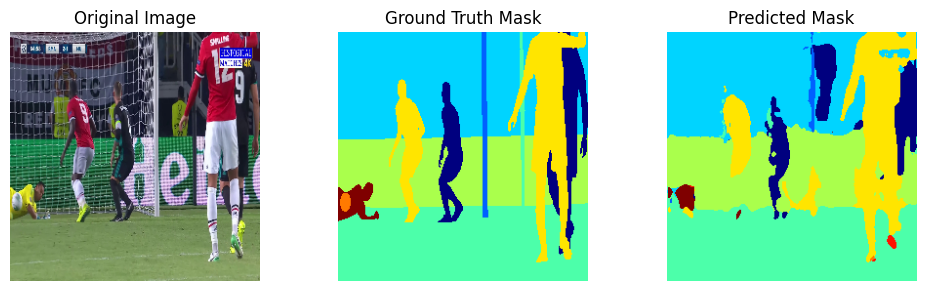

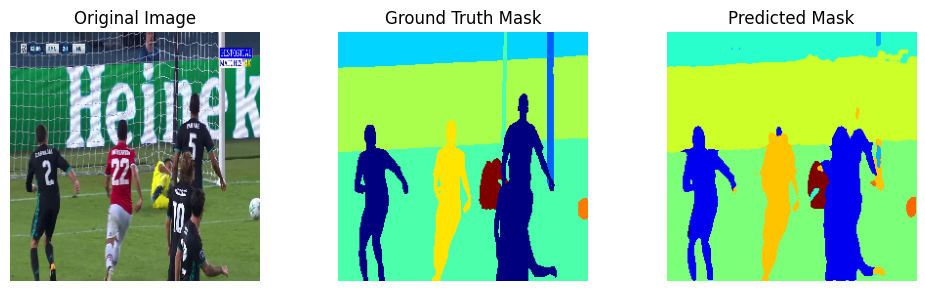

<Figure size 640x480 with 0 Axes>

In [46]:
model = load_model(model)
model_test(model, test_loader, visual_sample_num=15)

Улучшения работают: Dice score вырос на 19–32%, что критически важно для сегментации.

# Трансформерная сеть (Unet с бэкбоном mit_b5)

In [4]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A
import cv2
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def dice_score(pred, target, smooth=1e-6):

    num_classes = pred.shape[1]
    pred = torch.argmax(pred, dim=1)  # [B, H, W]

    dice = 0
    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        dice += (2. * intersection + smooth) / (union + smooth)

    return dice / num_classes


model = smp.Unet(
    encoder_name="mit_b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(color_to_label),
).to(device)


criterion = smp.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=0.0001)


def calculate_metrics(pred, target):

    metrics = {}
    metrics['loss'] = criterion(pred, target)
    metrics['dice_score'] = dice_score(pred, target)
    return metrics


def train_epoch(model, dataloader, optimizer):
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        metrics = calculate_metrics(outputs, masks)

        metrics['loss'].backward()
        optimizer.step()

        running_loss += metrics['loss'].item()
        running_dice += metrics['dice_score'].item()

    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)

    return epoch_loss, epoch_dice


def validate_epoch(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            metrics = calculate_metrics(outputs, masks)

            running_loss += metrics['loss'].item()
            running_dice += metrics['dice_score'].item()

    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)

    return epoch_loss, epoch_dice

# Основной цикл обучения
num_epochs = 25
best_dice = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")


    train_loss, train_dice = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")


    val_loss, val_dice = validate_epoch(model, val_loader)
    print(f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")


    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved!")


def test_model(model, dataloader):
    model.eval()
    running_dice = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            running_dice += dice_score(outputs, masks).item()

    return running_dice / len(dataloader)


model.load_state_dict(torch.load("best_model.pth"))
test_dice = test_model(model, test_loader)
print(f"Test Dice Score: {test_dice:.4f}")




Using device: cuda
Epoch 1/25


100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


Train Loss: 0.7501 | Train Dice: 0.0921
Val Loss: 0.5085 | Val Dice: 0.1164
Model saved!
Epoch 2/25


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Train Loss: 0.7014 | Train Dice: 0.2134
Val Loss: 0.4684 | Val Dice: 0.2073
Model saved!
Epoch 3/25


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Train Loss: 0.6759 | Train Dice: 0.2952
Val Loss: 0.4576 | Val Dice: 0.2660
Model saved!
Epoch 4/25


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Train Loss: 0.6340 | Train Dice: 0.3908
Val Loss: 0.4307 | Val Dice: 0.3075
Model saved!
Epoch 5/25


100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


Train Loss: 0.5575 | Train Dice: 0.4208
Val Loss: 0.3960 | Val Dice: 0.3731
Model saved!
Epoch 6/25


100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Train Loss: 0.5597 | Train Dice: 0.4457
Val Loss: 0.3611 | Val Dice: 0.4060
Model saved!
Epoch 7/25


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Train Loss: 0.5141 | Train Dice: 0.4619
Val Loss: 0.3380 | Val Dice: 0.4318
Model saved!
Epoch 8/25


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Train Loss: 0.4940 | Train Dice: 0.5040
Val Loss: 0.3211 | Val Dice: 0.4550
Model saved!
Epoch 9/25


100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Train Loss: 0.4796 | Train Dice: 0.4943
Val Loss: 0.2991 | Val Dice: 0.4077
Epoch 10/25


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Train Loss: 0.4434 | Train Dice: 0.5489
Val Loss: 0.2865 | Val Dice: 0.5054
Model saved!
Epoch 11/25


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Train Loss: 0.4279 | Train Dice: 0.5570
Val Loss: 0.2725 | Val Dice: 0.5100
Model saved!
Epoch 12/25


100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Train Loss: 0.4128 | Train Dice: 0.5611
Val Loss: 0.2652 | Val Dice: 0.5551
Model saved!
Epoch 13/25


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Train Loss: 0.3876 | Train Dice: 0.5841
Val Loss: 0.2549 | Val Dice: 0.5840
Model saved!
Epoch 14/25


100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Train Loss: 0.4096 | Train Dice: 0.5584
Val Loss: 0.2456 | Val Dice: 0.5981
Model saved!
Epoch 15/25


100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


Train Loss: 0.3828 | Train Dice: 0.5737
Val Loss: 0.2341 | Val Dice: 0.6016
Model saved!
Epoch 16/25


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Train Loss: 0.3814 | Train Dice: 0.6041
Val Loss: 0.2313 | Val Dice: 0.6393
Model saved!
Epoch 17/25


100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.3636 | Train Dice: 0.6264
Val Loss: 0.2226 | Val Dice: 0.6012
Epoch 18/25


100%|██████████| 20/20 [00:49<00:00,  2.45s/it]


Train Loss: 0.3444 | Train Dice: 0.6301
Val Loss: 0.2126 | Val Dice: 0.6953
Model saved!
Epoch 19/25


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Train Loss: 0.3471 | Train Dice: 0.7021
Val Loss: 0.2066 | Val Dice: 0.7268
Model saved!
Epoch 20/25


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Train Loss: 0.3052 | Train Dice: 0.6990
Val Loss: 0.1972 | Val Dice: 0.7447
Model saved!
Epoch 21/25


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.3112 | Train Dice: 0.7202
Val Loss: 0.1888 | Val Dice: 0.7570
Model saved!
Epoch 22/25


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.3064 | Train Dice: 0.7404
Val Loss: 0.1837 | Val Dice: 0.7604
Model saved!
Epoch 23/25


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Train Loss: 0.2911 | Train Dice: 0.7508
Val Loss: 0.1753 | Val Dice: 0.7764
Model saved!
Epoch 24/25


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Train Loss: 0.2686 | Train Dice: 0.7247
Val Loss: 0.1659 | Val Dice: 0.7921
Model saved!
Epoch 25/25


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Train Loss: 0.2735 | Train Dice: 0.7395
Val Loss: 0.1697 | Val Dice: 0.7740
Test Dice Score: 0.7039


# Улучшенный бейзлайн

Использование non_blocking=True для асинхронных передач, включение cudnn.benchmark для автоматической оптимизации, использование AdamW с weight decay

In [6]:
import os
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm
from collections import defaultdict


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.backends.cudnn.benchmark = True if torch.cuda.is_available() else False

# Улучшенная реализация метрик
class MetricCalculator:
    def __init__(self, num_classes, device='cuda'):
        self.num_classes = num_classes
        self.device = device
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes, device=self.device)
        self.union = torch.zeros(self.num_classes, device=self.device)

    def update(self, pred, target):
        pred = torch.argmax(pred, dim=1)
        for class_idx in range(self.num_classes):
            pred_mask = (pred == class_idx)
            target_mask = (target == class_idx)

            self.intersection[class_idx] += (pred_mask & target_mask).float().sum()
            self.union[class_idx] += (pred_mask | target_mask).float().sum()

    def get_metrics(self, smooth=1e-6):
        dice = (2 * self.intersection + smooth) / (self.intersection + self.union + smooth)
        iou = (self.intersection + smooth) / (self.union + smooth)
        return {
            'dice': dice.mean().item(),
            'iou': iou.mean().item(),
            'class_dice': dice.cpu().numpy(),
            'class_iou': iou.cpu().numpy()
        }

# Улучшенная модель с дополнительными параметрами
def create_model(num_classes):
    model = smp.Unet(
        encoder_name='mit_b5',
        encoder_weights='imagenet',
        in_channels=3,
        classes=num_classes,
        activation=None,
        decoder_attention_type='scse'
    )
    return model.to(device)

# Оптимизированный тренировочный цикл
class Trainer:
    def __init__(self, model, train_loader, val_loader, num_classes):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = smp.losses.DiceLoss(mode='multiclass')
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', patience=2, factor=0.5)
        self.metric_calculator = MetricCalculator(num_classes, device)
        self.best_score = 0.0
        self.history = defaultdict(list)

    def train_epoch(self):
        self.model.train()
        self.metric_calculator.reset()
        running_loss = 0.0

        for images, masks in tqdm(self.train_loader, desc='Training'):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            self.optimizer.zero_grad(set_to_none=True)
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            self.metric_calculator.update(outputs, masks)

        metrics = self.metric_calculator.get_metrics()
        epoch_loss = running_loss / len(self.train_loader)
        return {'loss': epoch_loss, **metrics}

    def validate(self):
        self.model.eval()
        self.metric_calculator.reset()
        running_loss = 0.0

        with torch.no_grad():
            for images, masks in tqdm(self.val_loader, desc='Validating'):
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)

                running_loss += loss.item()
                self.metric_calculator.update(outputs, masks)

        metrics = self.metric_calculator.get_metrics()
        epoch_loss = running_loss / len(self.val_loader)
        return {'loss': epoch_loss, **metrics}

    def run(self, num_epochs):
        for epoch in range(1, num_epochs + 1):
            print(f'\nEpoch {epoch}/{num_epochs}')


            train_metrics = self.train_epoch()
            for k, v in train_metrics.items():
                self.history[f'train_{k}'].append(v)


            val_metrics = self.validate()
            for k, v in val_metrics.items():
                self.history[f'val_{k}'].append(v)


            print(f"Train Loss: {train_metrics['loss']:.4f} | Train Dice: {train_metrics['dice']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f} | Val Dice: {val_metrics['dice']:.4f}")


            if val_metrics['dice'] > self.best_score:
                self.best_score = val_metrics['dice']
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_score': self.best_score,
                    'epoch': epoch
                }, 'best_model.pth')
                print('Model saved with Dice: {:.4f}'.format(self.best_score))

            # Обновление learning rate
            self.scheduler.step(val_metrics['dice'])

        return self.history


if __name__ == '__main__':

    num_classes = len(color_to_label)
    model = create_model(num_classes)


    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_classes=num_classes
    )


    history = trainer.run(num_epochs=25)


    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nBest model from epoch {checkpoint['epoch']} with Dice: {checkpoint['best_score']:.4f}")


    test_metric_calculator = MetricCalculator(num_classes, device)
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            test_metric_calculator.update(outputs, masks)

    test_metrics = test_metric_calculator.get_metrics()
    print(f"\nTest Metrics:")
    print(f"Dice: {test_metrics['dice']:.4f}")
    print(f"IoU: {test_metrics['iou']:.4f}")

Using device: cuda

Epoch 1/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train Loss: 0.7377 | Train Dice: 0.0642
Val Loss: 0.5196 | Val Dice: 0.1037
Model saved with Dice: 0.1037

Epoch 2/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Train Loss: 0.7303 | Train Dice: 0.1334
Val Loss: 0.4866 | Val Dice: 0.1756
Model saved with Dice: 0.1756

Epoch 3/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Train Loss: 0.6651 | Train Dice: 0.1870
Val Loss: 0.4594 | Val Dice: 0.2454
Model saved with Dice: 0.2454

Epoch 4/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Train Loss: 0.6165 | Train Dice: 0.2484
Val Loss: 0.4327 | Val Dice: 0.2803
Model saved with Dice: 0.2803

Epoch 5/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Train Loss: 0.5941 | Train Dice: 0.2844
Val Loss: 0.4278 | Val Dice: 0.2884
Model saved with Dice: 0.2884

Epoch 6/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Train Loss: 0.5887 | Train Dice: 0.3045
Val Loss: 0.4000 | Val Dice: 0.3091
Model saved with Dice: 0.3091

Epoch 7/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Train Loss: 0.5723 | Train Dice: 0.3286
Val Loss: 0.3871 | Val Dice: 0.3644
Model saved with Dice: 0.3644

Epoch 8/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train Loss: 0.5345 | Train Dice: 0.4112
Val Loss: 0.3745 | Val Dice: 0.4242
Model saved with Dice: 0.4242

Epoch 9/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Train Loss: 0.5172 | Train Dice: 0.4270
Val Loss: 0.3482 | Val Dice: 0.4454
Model saved with Dice: 0.4454

Epoch 10/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Train Loss: 0.4890 | Train Dice: 0.4417
Val Loss: 0.3235 | Val Dice: 0.4527
Model saved with Dice: 0.4527

Epoch 11/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train Loss: 0.4632 | Train Dice: 0.4717
Val Loss: 0.2979 | Val Dice: 0.5190
Model saved with Dice: 0.5190

Epoch 12/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Train Loss: 0.4594 | Train Dice: 0.5088
Val Loss: 0.2771 | Val Dice: 0.5337
Model saved with Dice: 0.5337

Epoch 13/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Train Loss: 0.4281 | Train Dice: 0.5340
Val Loss: 0.2668 | Val Dice: 0.5647
Model saved with Dice: 0.5647

Epoch 14/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Train Loss: 0.3975 | Train Dice: 0.5734
Val Loss: 0.2482 | Val Dice: 0.5977
Model saved with Dice: 0.5977

Epoch 15/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Train Loss: 0.3502 | Train Dice: 0.5991
Val Loss: 0.2216 | Val Dice: 0.6064
Model saved with Dice: 0.6064

Epoch 16/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Train Loss: 0.3367 | Train Dice: 0.6078
Val Loss: 0.2015 | Val Dice: 0.6109
Model saved with Dice: 0.6109

Epoch 17/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Train Loss: 0.3256 | Train Dice: 0.6023
Val Loss: 0.1965 | Val Dice: 0.6098

Epoch 18/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Train Loss: 0.3088 | Train Dice: 0.5975
Val Loss: 0.1859 | Val Dice: 0.6283
Model saved with Dice: 0.6283

Epoch 19/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Train Loss: 0.2903 | Train Dice: 0.6219
Val Loss: 0.1778 | Val Dice: 0.6313
Model saved with Dice: 0.6313

Epoch 20/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Train Loss: 0.2962 | Train Dice: 0.6241
Val Loss: 0.1767 | Val Dice: 0.6268

Epoch 21/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Train Loss: 0.2584 | Train Dice: 0.6359
Val Loss: 0.1659 | Val Dice: 0.6395
Model saved with Dice: 0.6395

Epoch 22/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Train Loss: 0.2621 | Train Dice: 0.6403
Val Loss: 0.1658 | Val Dice: 0.6384

Epoch 23/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Train Loss: 0.2510 | Train Dice: 0.6432
Val Loss: 0.1663 | Val Dice: 0.6396
Model saved with Dice: 0.6396

Epoch 24/25


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Train Loss: 0.2465 | Train Dice: 0.6487
Val Loss: 0.1580 | Val Dice: 0.6461
Model saved with Dice: 0.6461

Epoch 25/25


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Train Loss: 0.2370 | Train Dice: 0.6482
Val Loss: 0.1541 | Val Dice: 0.6481
Model saved with Dice: 0.6481

Best model from epoch 25 with Dice: 0.6481


Testing: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Test Metrics:
Dice: 0.6214
IoU: 0.5499
